In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import skellam
import math
import scipy.special
import matplotlib.pyplot as plt

In [2]:
#Create a Dataframe with 4 season
Data10=pd.read_csv("../Data/2009-2010.csv")
Data9=pd.read_csv("../Data/2008-2009.csv")
Data8=pd.read_csv("../Data/2007-2008.csv")
Data7=pd.read_csv("../Data/2006-2007.csv")
Data=pd.concat([Data7,Data8,Data9,Data10],sort=False,ignore_index=True)
Data=Data[['HomeTeam','AwayTeam','FTHG','FTAG','FTR']]
Data.columns=['Home','Away','HG','AG','Result']
Out=["Lecce","Messina","Ascoli","Reggina","Empoli","Torino"]
for out in Out:
    Data = Data.loc[Data.Home != out]
    Data = Data.loc[Data.Away != out]
Data=Data.reset_index()
Team=Data.Home.value_counts().index


In [48]:
#Create a dataframe with the coefficients to update
coef=pd.DataFrame({'Team':Team})
coef['Att']=np.random.normal(0,0.01,len(coef))
coef['Dif']=np.random.normal(0,0.01,len(coef))
coef.iloc[0]['Att']=coef.iloc[0]['Att'] -sum(coef['Att'].values)
coef.iloc[0]['Dif']=coef.iloc[0]['Dif'] -sum(coef['Dif'].values)
#In order to have identifiability of the covariates 
coef=coef.set_index('Team').sort_index()

delta = np.random.normal(0,0.01)
coef

C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Att,Dif
Team,,
Atalanta,-0.000873,0.005270
Bari,0.021000,-0.001493
Bologna,-0.002623,0.004976
Cagliari,0.001328,0.007874
Catania,0.010486,0.011901
Chievo,-0.003936,0.005663
Fiorentina,-0.003237,-0.021852
Genoa,0.012754,-0.005153
Inter,-0.007674,0.024563


In [4]:
#Function to calculate the means for the Poisson distribution
def score_coef(att,dif,delta,Data):
    mu1=np.array([])
    mu2=np.array([])
    for i in Data.index:
        m1=np.exp(delta+att.loc[Data.loc[i].Home]-dif.loc[Data.loc[i].Away])
        m2=np.exp(att.loc[Data.loc[i].Away]-dif.loc[Data.loc[i].Home])
        mu1=np.append(mu1,m1)
        mu2=np.append(mu2,m2)
    return mu1, mu2

In [5]:
def log_prior (coef_att,coef_dif,delta):
    e= norm.logpdf(delta, loc=0, scale=0.1)
    for i in range(len(coef_att)):
        e=+ norm.logpdf(coef_att[i], loc=0, scale=0.1)+ norm.logpdf(coef_dif[i], loc=0, scale=0.01)
    return e

In [6]:
#Our posterior distribution should follow a Poisson process with the mean coefficient to be adjusted 
def log_poisson(mu1,mu2,Data):
    D=0
    for i in range(len(Data)):
        D+=Data['HG'].iloc[i]*np.log(mu1.iloc[i])-mu1.iloc[i]-np.log(math.factorial(Data['HG'].iloc[i]))+Data['AG'].iloc[i]*np.log(mu2.iloc[i])-mu2.iloc[i]-np.log(math.factorial(Data['AG'].iloc[i]))
    return D

In [7]:
#log of unormalised distr
def log_tot (X):
    coef_att=np.concatenate(([-sum(X[1:20])],X[1:20]))
    coef_def=np.concatenate(([-sum(X[20:])],X[20:]))
    H=X[0]
    N=log_prior(coef_att,coef_def,H)
    coef['i1']=coef_att
    coef['i2']=coef_def
    L1,L2=score_coef(coef['i1'],coef['i2'],H,Data)
    Data['j1']=L1
    Data['j2']=L2
    N+=log_poisson(Data['j1'],Data['j2'],Data)
    return N 

In [8]:
#Approximate the gradient of our log_posterior likelihood by finite differences 
def grad(X,h=0.01):
    X_1=np.copy(X)
    X_2=np.copy(X)
    grad=np.ones(len(X_1))
    for i in range(0,len(X_1)):
        X_1[i]+=h
        X_2[i]-=h
        unnorm1=log_tot(X_1)
        unnorm2=log_tot(X_2)
        grad[i]=(unnorm1-unnorm2)/(2*h)
        X_2[i]+=h
        X_1[i]-=h
    return grad
       
    

In [9]:
#h(theta_n|theta_prop) for the acceptance ratio
def qprop(X,Y,tau,grad_x,grad_y):
    dif=X-Y
    c=-1/(4*tau)
    norm1=c*np.linalg.norm(-dif-np.multiply(tau,grad_x))**2
    norm2=c*np.linalg.norm(dif-np.multiply(tau,grad_y))**2
    return norm1-norm2


In [10]:
mu1, mu2=score_coef(coef['Att'],coef['Dif'],delta,Data)
Data['mu1']=mu1
Data['mu2']=mu2


In [56]:
def MALA(max_iter,theta0,Data):
    #create vectors to save coef and means at each iteration
    totnameatt= list()
    totnamedef= list()
    tau=0.0001
    theta_t = theta0 
    ret=0
    coef['Sum_Att']=coef['Att']
    coef['Sum_Dif']=coef['Dif']
    for k in range(max_iter):
        #Update our coef vector 
        gradient1=grad(theta_t)
        theta2_t=np.copy(theta_t)+tau/2*gradient1+6*np.sqrt(tau)*np.random.normal(0,0.1,39)
        gradient2=grad(theta2_t)
        
        #Calculate the new coeficient         
        coef['New_Att']=np.concatenate(([-sum(theta2_t[1:20])],theta2_t[1:20]))
        coef['New_Dif']=np.concatenate(([-sum(theta2_t[20:])],theta2_t[20:]))
        mu1 ,mu2=score_coef(coef['New_Att'],coef['New_Dif'],theta2_t[0],Data)
        Data['new_mu1']=mu1
        Data['new_mu2']=mu2
        L1=-log_tot(theta_t)
        L2=-log_tot(theta2_t)
        #Calculate the acceptance Ratio
        R=qprop(theta_t,theta2_t,tau,gradient1,gradient2)
        alpha= min(1,np.exp((L2-L1+R)))   
        print(alpha)
        u=np.random.uniform(0,1)
        if u<alpha:
            #Save updated coefficients
            name_att = "iter"+str(ret)+"att"
            name_def= "iter"+str(ret)+"def"
            coef[name_att]=coef['New_Att']
            coef[name_def]=coef['New_Dif']
            Data[name_att]=Data['new_mu1']
            Data[name_def]=Data['new_mu2']
            Data['mu1']=Data['new_mu1']
            Data['mu2']=Data['new_mu2']
            theta_t=np.copy(theta2_t)
            ret+=1
            totnameatt.append(name_att)
            totnamedef.append(name_def)
            print(k)
            coef['Sum_Att']+=coef['New_Att']
            coef['Sum_Dif']+=coef['New_Dif']
    if ret!=0:
        coef['Sum_Att']=coef['Sum_Att']/ret
        coef['Sum_Dif']=coef['Sum_Dif']/ret
    
            
    return coef, theta_t[0], ret


In [57]:
theta0=np.concatenate(([[delta],coef['Att'][1:20],coef['Dif'][1:20]]))

In [58]:
theta0

array([ 0.00069425,  0.02100023, -0.0026234 ,  0.0013279 ,  0.010486  ,
       -0.00393621, -0.00323743,  0.01275362, -0.00767406, -0.01410371,
        0.00049118,  0.00200501, -0.01637622, -0.01593614, -0.00037217,
        0.00826515, -0.00183012, -0.00427425,  0.00133392,  0.0013964 ,
       -0.00149323,  0.00497562,  0.0078741 ,  0.01190065,  0.0056634 ,
       -0.02185194, -0.00515278,  0.02456349, -0.01252584,  0.00620293,
       -0.00795924, -0.00331052, -0.01482039, -0.00418468,  0.01118103,
       -0.01039253, -0.01033217,  0.01042973,  0.01058654])

In [59]:
Coef_club, delta1,it=MALA(150,theta0,Data)


k
0.21381523960909724
k
0.2811693408956695
1
k
0.4359416329669763
2
k
0.2890136303122255
3
k
0.7148061888905856
4
k
0.49052459734024023
5
k
0.4916603450283645
6
k
0.6577161071527713
k
0.6399121757211205
8
k
0.6369270603396375
9
k
0.6093669732728042
10
k
0.601466166625471
k
0.5214204409987975
12
k
0.6048929146925583
k
0.7579314215436391
14
k
0.7692974793027488
15
k
0.6192578172342801
16
k
0.7194152502761667
k
0.7099683006253202
18
k
0.8153953419282972
19
k
0.9383955460263295
20
k
1
21
k
0.6043673865313411
k
1
23
k
0.43145286202396066
24
k
0.7253759613812342
25
k
1
26
k
0.795364246863473
27
k
0.8267075224201759
28
k
1
29
k
1
30
k
0.8511219890839049
31
k
0.9262832407133277
32
k
1
33
k
0.4961719789096647
34
k
0.9574260472592823
35
k
0.9925608378650598
36
k
0.9905900992630329
37
k
1
38
k
0.8432226441750931
39
k
1
40
k
0.9249434305113188
41
k
1
42
k
1
43
k
0.9560619678593911
44
k
0.8790127668388182
45
k
1
46
k
0.8248074881140222
47
k
0.9358318842458915
48
k
0.9867998882164989
49
k
1
50
k
0.9

In [62]:
Coef_club['Home_Adv']=delta1
Coef_club.to_csv('Coef_MALA_Poiss.csv')

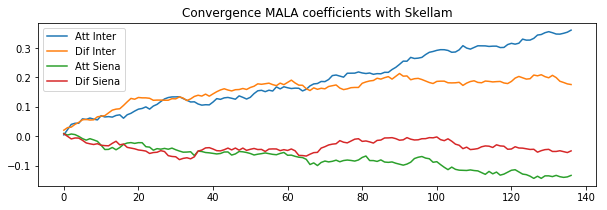

In [63]:
#Plot the evolution of Attacking and difensive Coefficients of Inter and Siena 
def vect(coef):
    
    vect_att_i=[]
    vect_def_i=[]
    vect_att_s=[]
    vect_def_s=[]
    for i in range(0,it):
        vect1=[]
        vect2=[]
        vect3=[]
        vect4=[]
        col_att = "iter"+str(i)+"att"
        col_def = "iter"+str(i)+"def"
        vect1.append(coef[col_att][8])
        vect2.append(coef[col_def][8])
        vect3.append(coef[col_att][18])
        vect4.append(coef[col_def][18])
        vect_att_i.append(vect1)
        vect_def_i.append(vect2)
        vect_att_s.append(vect3)
        vect_def_s.append(vect4)
    plt.figure(figsize=(10,3))
    plt.plot(vect_att_i, label='Att Inter')
    plt.plot(vect_def_i,label='Dif Inter')
    plt.plot(vect_att_s, label='Att Siena')
    plt.plot(vect_def_s,label='Dif Siena')
    plt.legend(loc='upper left')
    plt.title('Convergence MALA coefficients with Poisson')
    plt.savefig('MALA_Poisson.png')
    plt.show()
    return 
vect(Coef_club)


In [61]:
Coef_club

,Att,Dif,Sum_Att,Sum_Dif,i1,i2,New_Att,New_Dif,iter0att,iter0def,...,iter132att,iter132def,iter133att,iter133def,iter134att,iter134def,iter135att,iter135def,iter136att,iter136def
Team,,,,,,,,,,,,,,,,,,,,,
Atalanta,-0.000873,0.005270,-0.030225,-0.093823,-0.001461,-0.111662,-0.001461,-0.111662,-0.005021,-0.028622,...,-0.048992,-0.120721,-0.050008,-0.108143,-0.046870,-0.077975,0.012183,-0.094925,-0.001461,-0.111662
Bari,0.021000,-0.001493,-0.038427,0.023878,-0.061484,0.078586,-0.061484,0.078586,0.025154,-0.002057,...,-0.048867,0.043861,-0.056077,0.048843,-0.052948,0.058639,-0.056553,0.075447,-0.061484,0.078586
Bologna,-0.002623,0.004976,-0.075596,0.004727,-0.103321,-0.036752,-0.103321,-0.036752,-0.004098,0.004220,...,-0.099089,-0.026230,-0.099501,-0.026629,-0.091827,-0.029374,-0.099616,-0.036138,-0.103321,-0.036752
Cagliari,0.001328,0.007874,-0.013683,-0.030845,0.002955,-0.047574,0.002955,-0.047574,0.003767,0.006159,...,-0.002357,-0.040800,-0.007469,-0.043729,0.000693,-0.047527,-0.006477,-0.045578,0.002955,-0.047574
Catania,0.010486,0.011901,-0.054901,0.014891,-0.153973,0.016808,-0.153973,0.016808,0.012354,0.016253,...,-0.142518,0.043991,-0.142034,0.038404,-0.135550,0.034107,-0.139479,0.022938,-0.153973,0.016808
Chievo,-0.003936,0.005663,-0.107515,0.023584,-0.202401,0.037393,-0.202401,0.037393,-0.004343,0.008320,...,-0.195731,0.045336,-0.193626,0.046548,-0.194293,0.038262,-0.200094,0.039246,-0.202401,0.037393
Fiorentina,-0.003237,-0.021852,0.014943,0.020859,0.029880,0.105475,0.029880,0.105475,-0.003833,-0.018749,...,0.046352,0.078744,0.039915,0.089640,0.039148,0.088990,0.037075,0.094540,0.029880,0.105475
Genoa,0.012754,-0.005153,0.017934,-0.067640,0.051072,-0.086771,0.051072,-0.086771,0.006333,-0.001630,...,0.044477,-0.105331,0.044315,-0.096976,0.048918,-0.095945,0.045134,-0.083606,0.051072,-0.086771
Inter,-0.007674,0.024563,0.194547,0.158007,0.360927,0.176075,0.360927,0.176075,0.004971,0.020853,...,0.347661,0.199690,0.347364,0.187230,0.350216,0.183021,0.353976,0.178257,0.360927,0.176075
